## 数据处理
### 导入所需的package

In [1]:
import osmnx as ox
import geopandas as gpd
import os

# 画图
import geopandas as gpd
import matplotlib.pyplot as plt

### 从osm上获取City of Londond的所有道路

In [2]:
# 1. 获取 City of London 区域边界
place_name = "City of London, London, England, United Kingdom"
gdf = ox.geocode_to_gdf(place_name)

# 2. 自定义过滤器：抓取所有适合骑行、包含 cycleway 的道路（参考官方源代码逻辑）
custom_filter = (
    '["highway"]["area"!~"yes"]'
    '["highway"!~"abandoned|bus_guideway|construction|corridor|elevator|escalator|footway|'
    'motor|no|planned|platform|proposed|raceway|razed|steps"]'
    '["bicycle"!~"no"]["service"!~"private"]'
)

# 3. 下载图形网络数据
graph = ox.graph_from_polygon(gdf.geometry[0], custom_filter=custom_filter)

# 4. 转为 GeoDataFrame（仅保留边）
edges = ox.graph_to_gdfs(graph, nodes=False)

# 5. 结果为所有开放使用、包含或适合骑行的道路
bike_lanes = edges

# 6. 确保输出文件夹存在
output_dir = "../data"
os.makedirs(output_dir, exist_ok=True)

# 7. 导出为 GeoJSON 文件
output_path = os.path.join(output_dir, "city_of_london_bike_lanes.geojson")
bike_lanes.to_file(output_path, driver="GeoJSON")

print(f"✅ 导出成功：{output_path}")

✅ 导出成功：../data\city_of_london_bike_lanes.geojson


### 看一眼highway里面有啥

### 画出来看看

Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field ref: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5
Skipping field est_width: unsupported OGR type: 5


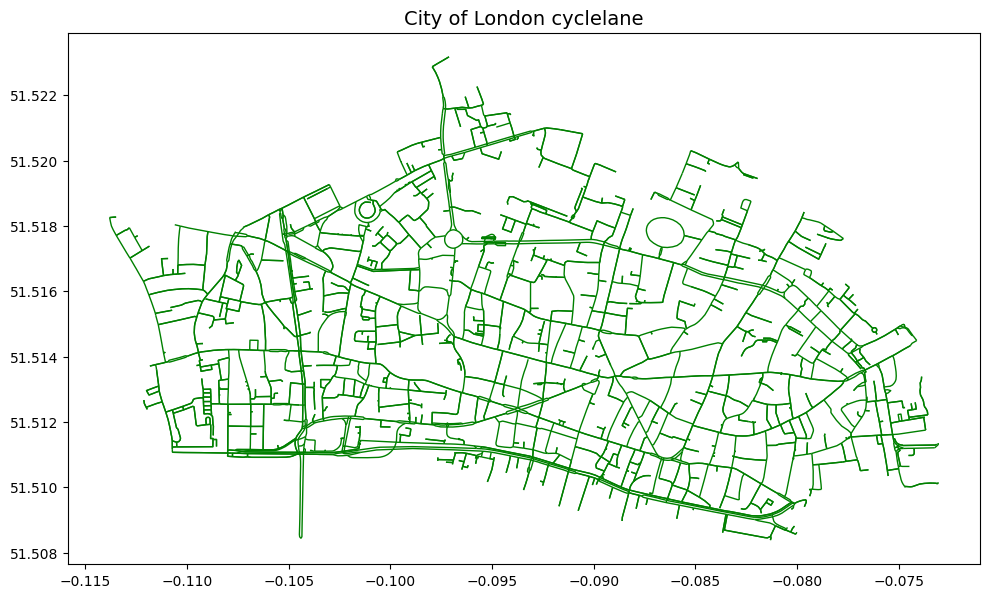

In [3]:
# 1. 读取刚才导出的 GeoJSON 文件
gdf = gpd.read_file("../data/city_of_london_bike_lanes.geojson")

# 2. 设置绘图大小
fig, ax = plt.subplots(figsize=(10, 10))

# 3. 绘图（线）
gdf.plot(ax=ax, linewidth=1, edgecolor='green')

# 4. 设置图标题和去除坐标轴
ax.set_title("City of London cyclelane", fontsize=14)
# ax.axis("off")

# 5. 显示图像
plt.tight_layout()
plt.show()

In [ ]:
# LTS 估算函数
def estimate_lts_conveyal(functional_class, has_bike_lane, speed_limit, lane_count):
    # conservative 默认值估算缺失项
    if speed_limit is None:
        speed_limit = {
            "residential": 25,
            "tertiary": 30,
            "secondary": 35,
            "primary": 40,
            "trunk": 45
        }.get(functional_class, 35)

    if lane_count is None:
        lane_count = {
            "residential": 2,
            "tertiary": 2,
            "secondary": 3,
            "primary": 4,
            "trunk": 4
        }.get(functional_class, 3)

    if has_bike_lane is None:
        has_bike_lane = False  # 保守认为“没有”

    # 分类逻辑
    if functional_class in ["residential", "living_street"] and has_bike_lane and speed_limit <= 25:
        return 1
    elif has_bike_lane and speed_limit <= 30 and lane_count <= 2:
        return 2
    elif not has_bike_lane and functional_class in ["residential", "tertiary"] and speed_limit <= 30:
        return 3
    elif lane_count >= 4 or speed_limit >= 45:
        return 4
    elif functional_class in ["primary", "secondary", "trunk"] and not has_bike_lane:
        return 4
    elif has_bike_lane and speed_limit > 35:
        return 3
    else:
        return 2  # fallback

In [ ]:
import os
import osmnx as ox
import geopandas as gpd

# -------------------------------
# LTS 估算函数
def estimate_lts_conveyal(functional_class, has_bike_lane, speed_limit, lane_count):
    # conservative 默认值估算缺失项
    if speed_limit is None:
        speed_limit = {
            "residential": 25,
            "tertiary": 30,
            "secondary": 35,
            "primary": 40,
            "trunk": 45
        }.get(functional_class, 35)

    if lane_count is None:
        lane_count = {
            "residential": 2,
            "tertiary": 2,
            "secondary": 3,
            "primary": 4,
            "trunk": 4
        }.get(functional_class, 3)

    if has_bike_lane is None:
        has_bike_lane = False  # 保守认为“没有”

    # 分类逻辑
    if functional_class in ["residential", "living_street"] and has_bike_lane and speed_limit <= 25:
        return 1
    elif has_bike_lane and speed_limit <= 30 and lane_count <= 2:
        return 2
    elif not has_bike_lane and functional_class in ["residential", "tertiary"] and speed_limit <= 30:
        return 3
    elif lane_count >= 4 or speed_limit >= 45:
        return 4
    elif functional_class in ["primary", "secondary", "trunk"] and not has_bike_lane:
        return 4
    elif has_bike_lane and speed_limit > 35:
        return 3
    else:
        return 2  # fallback

# -------------------------------
# 1. 获取 City of London 边界
place_name = "City of London, London, England, United Kingdom"
gdf = ox.geocode_to_gdf(place_name)

# 2. 设置过滤器（适合骑行的道路）
custom_filter = (
    '["highway"]["area"!~"yes"]'
    '["highway"!~"abandoned|bus_guideway|construction|corridor|elevator|escalator|footway|'
    'motor|no|planned|platform|proposed|raceway|razed|steps"]'
    '["bicycle"!~"no"]["service"!~"private"]'
)

# 3. 下载图形网络
graph = ox.graph_from_polygon(gdf.geometry[0], custom_filter=custom_filter)
edges = ox.graph_to_gdfs(graph, nodes=False)

# -------------------------------
# 4. 清理和准备字段以用于 LTS 估算
def to_bool(val):
    if val in [True, "yes", "Yes", "YES", "lane", "track"]:
        return True
    return False

edges["functional_class"] = edges["highway"].astype(str)

# ➤ 判断是否含有 cycleway 字段（避免 KeyError）
if "cycleway" in edges.columns:
    edges["has_bike_lane"] = edges["cycleway"].astype(str).apply(lambda x: to_bool(x) if x != "nan" else False)
else:
    edges["has_bike_lane"] = False  # 如果没有字段，就全设为 False

edges["speed_limit"] = edges["maxspeed"].apply(
    lambda x: float(x.split()[0]) if isinstance(x, str) and x.split()[0].isdigit() else None
)

edges["lane_count"] = edges["lanes"].apply(
    lambda x: int(x) if isinstance(x, str) and x.isdigit() else None
)

# -------------------------------
# 5. 应用估算函数
edges["lts"] = edges.apply(
    lambda row: estimate_lts_conveyal(
        row["functional_class"],
        row["has_bike_lane"],
        row["speed_limit"],
        row["lane_count"]
    ),
    axis=1
)

# -------------------------------
# 6. 导出结果
output_dir = "../data"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "city_of_london_highway_lts.geojson")
edges.to_file(output_path, driver="GeoJSON")

print(f"✅ 导出成功，含 LTS 估算字段：{output_path}")


✅ 导出成功，含 LTS 估算字段：../data\city_of_london_highway_lts.geojson


Skipping field highway: unsupported OGR type: 5
Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field ref: unsupported OGR type: 5
Skipping field access: unsupported OGR type: 5
Skipping field width: unsupported OGR type: 5
Skipping field est_width: unsupported OGR type: 5
Skipping field functional_class: unsupported OGR type: 5
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_48580\2402862590.py:36: UserWarning: Glyph 31561 (\N{CJK UNIFIED IDEOGRAPH-7B49}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_48580\2402862590.py:36: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_48580\2402862590.py:36: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Lenovo\AppDat

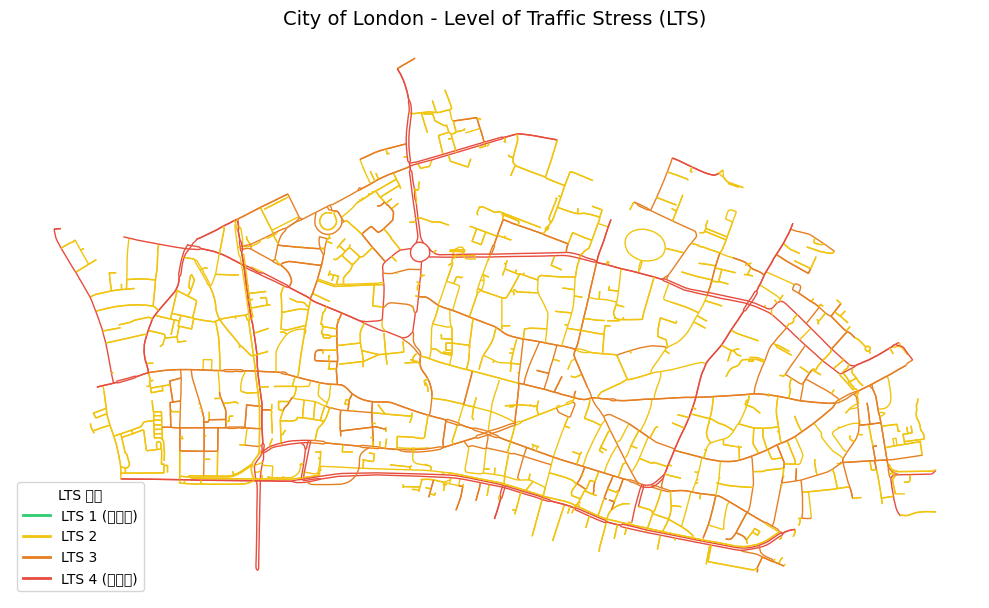

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. 读取含 LTS 的文件
gdf = gpd.read_file("../data/city_of_london_highway_lts.geojson")

# 2. 设置颜色映射（LTS: 1=绿，2=黄，3=橙，4=红）
lts_colors = {
    1: "#2ECC71",   # green
    2: "#F1C40F",   # yellow
    3: "#E67E22",   # orange
    4: "#E74C3C"    # red
}

# 3. 创建颜色列
gdf["color"] = gdf["lts"].map(lts_colors)

# 4. 绘图
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, linewidth=1, color=gdf["color"])

# 添加标题和图例（可选）
ax.set_title("City of London - Level of Traffic Stress (LTS)", fontsize=14)
ax.axis("off")

# 添加图例
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color="#2ECC71", lw=2, label="LTS 1 (最安全)"),
    Line2D([0], [0], color="#F1C40F", lw=2, label="LTS 2"),
    Line2D([0], [0], color="#E67E22", lw=2, label="LTS 3"),
    Line2D([0], [0], color="#E74C3C", lw=2, label="LTS 4 (高压力)"),
]
ax.legend(handles=legend_elements, title="LTS 等级", loc="lower left")

plt.tight_layout()
plt.show()
